In [23]:
from typing import List, Dict
import math
import json
import pickle
import os

import casadi as cas
import numpy as np
import numpy.linalg as npl
from scipy import signal
from dataclasses import dataclass
import matplotlib.pyplot as plt
import cvxpy as cp

from IOData.IOData import IOData, InputRule
from IOData.IODataWith_l import IODataWith_l
from System.ErrorKinematicAcceLATI import LinearizedErrorKinematicAcceModel, LinearizedErrorKinematicAcceModelParams, KinematicAcceModelParams, KinematicAcceModel
from SafetyFilters.TrackFilter import SafetyFilterForTrack
from SafetyFilters.NominalFewSlack_Tightened_LTAISSGiven import NominalFewSlackTightenedDDSafetyFilter, NominalFewSlackTightenedSFParams
from SafetyFilters.DDSF import SFParams
from tools.simple_track_generator import trackGenerator, line, arc

In [24]:
# parameters for kinematic model
l_r = 0.052
l_f = 0.038
# sampling time, control and output constraints
Ts = 1/100
a_min, a_max = -5, 6
delta_max = 0.35*math.pi
# y_max = 0.25
# x_max = 1
t = 0.3 # track radius parameter
track_width = 0.5 # track width parameter, width of the whole track!
density = 300 # density of the track points

v_min, v_max = -3, 5
mu_min, mu_max = -0.5*math.pi, 0.5*math.pi

# track parameters
track_start_point = np.array([0,0,0]) # satrt point of track, [x_p0, y_p0, Psi_0]
# steady state speed
v_0 = 1.5

# noise level for online observation
n_x = 0.001
n_y = 0.001
n_psi = 0.01
n_v = 0.005
# noise level for dataset
n_e_lat_max = 0.002
n_mu_max = 0.01
n_v_max = 0.005
n_l_max = 0.002

# maximum control inputs for collecting dataset
a_d_max = 2
delta_d_max = 5e-2
t_data = 10.0
length = int(t_data/Ts) # length of dataset

# maximum control inputs for simulation
a_sim = 7
delta_sim = 0.2*math.pi

o=3
A_y = np.matrix(np.vstack((
    np.hstack(( np.eye(2),np.zeros((2,o-2)) )),
    np.hstack(( -np.eye(2),np.zeros((2,o-2)) ))
)))
# A_y = np.matrix(np.vstack((
#     np.hstack(( np.eye(1),np.zeros((1,o-1)) )),
#     np.hstack(( -np.eye(1),np.zeros((1,o-1)) ))
# )))
A_n = np.matrix(np.vstack(( np.eye(o), -np.eye(o) )))

# controlling parameters
L=int(0.5/Ts)
lag=9
steps=3
m = 2
# initial state of system in simulation
exact_state_0 = np.array([0,0,0,0])

# simulation time and steps
T = 5
N = int(T/Ts)
N_block = int(N/steps)
J = int(N_block/8) # Save predicted trajectory every J blocks

# use saved data or not
use_saved_data = False
# save data or not
save_data = True

In [25]:
from tools.track_functions import demo_track
def oval_track(gen: trackGenerator, t: float, track_start_point: np.ndarray) -> trackGenerator:
    next = gen.straight(track_start_point, 3*t)
    next = gen.left_turn(next, t, np.pi)
    next = gen.straight(next, 6*t)
    next = gen.left_turn(next, t, np.pi)
    next = gen.straight(next, 3*t)
    return gen
# generate a track, for generating datasets, systems and filters
gen = trackGenerator(density, track_width)
oval_track(gen, t, track_start_point)
len(gen.chainOfSegments)

5

In [26]:
# create datasets. for demo track, we only need three datasets
if use_saved_data:
    with open(os.path.join(os.getcwd(), 'datasets', f'io_datas_{t_data}_{Ts}.pkl'), 'rb') as read_file:
        io_datas: Dict[float, IODataWith_l] = pickle.load(read_file)
    for cur in [0, 1/t, -1/t]:
        io_datas[cur].update_depth(lag+L)
        io_datas[cur]._A_l_used = io_datas[cur].get_l_estimation_matrix()
else:
    import os
    io_datas = {}
    for cur in [0, 1/t, -1/t]:
        sys = LinearizedErrorKinematicAcceModel(
            LinearizedErrorKinematicAcceModelParams(
                    KinematicAcceModelParams(l_r=l_r,l_f=l_f,Ts=Ts),
                    cur = cur,
                    state_s0=np.array([0,0,0]),
                    v_0 = v_0,
                    A_n = A_n,
                    # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_v_max],[n_x_max],[n_y_max],[n_psi_max],[n_v_max]]),
                    # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_x_max],[n_y_max],[n_psi_max]]),
                    b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_v_max],[n_e_lat_max],[n_mu_max],[n_v_max]]),
                    # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_e_lat_max],[n_mu_max]]),
                    # b_n = np.matrix([[n_e_lat_max],[n_e_lat_max]]),),
                ),
            state_0=exact_state_0)
        zero_input = sys.get_zero_input()
        zero_state = sys.get_zero_state()
        sys.set_error_state(zero_state)
        io_data = IODataWith_l(
                    L+lag, sys=sys, input_rule=InputRule.RANDOM_2_WITH_MEAN, mean_input=np.matrix(zero_input).transpose(), length=length,
                    A_u_d=np.matrix('1 0; 0 1; -1 0; 0 -1'), b_u_d=np.matrix([[a_d_max],[delta_d_max],[a_d_max],[delta_d_max]]),
                    n_l = n_l_max, lag = lag, L = L, N_l = int(length/2), K_l = 5)
        io_datas[cur] = io_data
    if save_data:
        with open(os.path.join(os.getcwd(), 'datasets', f'io_datas_{t_data}_{Ts}.pkl'), 'wb') as file:
            pickle.dump(io_datas, file)

In [27]:
# create systems and safety filters
systems = []
filter_params = []
for segment in gen.chainOfSegments:
    if isinstance(segment, line):
        psi_0 = math.atan2(segment.y1-segment.y0, segment.x1-segment.x0, )
        system_params = LinearizedErrorKinematicAcceModelParams(
            KinematicAcceModelParams(l_r, l_f, Ts),
            cur = 0,
            state_s0 = np.array([segment.x0, segment.y0, psi_0]),
            v_0 = v_0,
            A_u = np.matrix('1 0; 0 1; -1 0; 0 -1'),
            b_u = np.matrix([[a_max],[delta_max],[-a_min],[delta_max]]),
            # A_y = np.matrix('1 0 0 0; 0 1 0 0; -1 0 0 0; 0 -1 0 0'),
            A_y = A_y,
            # b_y = np.matrix([[t],[t]]),
            b_y = np.matrix([[track_width/2],[mu_max],[track_width/2],[-mu_min]]),
            # A_n = A_n,
            # # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_v_max],[n_x_max],[n_y_max],[n_psi_max],[n_v_max]]),
            # # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_x_max],[n_y_max],[n_psi_max]]),
            # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_v_max],[n_e_lat_max],[n_mu_max],[n_v_max]]),
            # # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_e_lat_max],[n_mu_max]]),
            # # b_n = np.matrix([[n_e_lat_max],[n_e_lat_max]]),
        )
        # initial state does not matter that much
        systems.append(LinearizedErrorKinematicAcceModel(system_params, np.array([0,0,0,0])))
        filter_params.append(NominalFewSlackTightenedSFParams(
            L=L, lag=lag, R=np.matrix('1 0; 0 100'), lam_sig=50000, epsilon=1e-3,
            c=[
                [0.35*track_width/2, 0.1*track_width/2, 0.05*track_width/2, 0.01*track_width/2],
                [0.3*mu_max, 0.1*mu_max, 0.05*mu_max, 0.01*mu_max],
                # [0.5*mu_max, 0.2*mu_max, 0.1*mu_max, 0.01*mu_max],
            ],
            sf_params=SFParams(steps=steps, verbose=False, solver=cp.MOSEK,
                            solver_args={'mosek_params':{
                                'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':5e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_INFEAS':1e-5,
                                'MSK_IPAR_INTPNT_MAX_ITERATIONS': 30000}}),
            steady_input=np.array([0,0]),
            steady_output=np.array([0,0,0])
            ))
    elif isinstance(segment, arc):
        unit_from_center = np.array([np.cos(segment.theta_s), np.sin(segment.theta_s)])
        x_p0 = segment.x0 + unit_from_center[0]*segment.radius
        y_p0 = segment.y0 + unit_from_center[1]*segment.radius
        if segment.theta_f > segment.theta_s: # left hand turn
            cur = segment.curvature
            psi_0 = segment.theta_s + 0.5*math.pi
        else: # right hand turn
            cur = -segment.curvature
            psi_0 = segment.theta_s - 0.5*math.pi
        system_params = LinearizedErrorKinematicAcceModelParams(
            KinematicAcceModelParams(l_r, l_f, Ts),
            cur = cur,
            state_s0 = np.array([x_p0, y_p0, psi_0]),
            v_0 = v_0,
            A_u = np.matrix('1 0; 0 1; -1 0; 0 -1'),
            b_u = np.matrix([[a_max],[delta_max],[-a_min],[delta_max]]),
            # A_y = np.matrix('1 0 0 0; 0 1 0 0; -1 0 0 0; 0 -1 0 0'),
            A_y = A_y,
            # b_y = np.matrix([[t],[t]]),
            b_y = np.matrix([[t],[mu_max],[t],[-mu_min]]),
            # A_n = A_n,
            # # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_v_max],[n_x_max],[n_y_max],[n_psi_max],[n_v_max]]),
            # # b_n = np.matrix([[n_x_max],[n_y_max],[n_psi_max],[n_x_max],[n_y_max],[n_psi_max]]),
            # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_v_max],[n_e_lat_max],[n_mu_max],[n_v_max]]),
            # # b_n = np.matrix([[n_e_lat_max],[n_mu_max],[n_e_lat_max],[n_mu_max]]),
            # # b_n = np.matrix([[n_e_lat_max],[n_e_lat_max]]),
        )
        # initial state does not matter that much
        systems.append(LinearizedErrorKinematicAcceModel(system_params, np.array([0,0,0,0])))
        filter_params.append(NominalFewSlackTightenedSFParams(
            L=L, lag=lag, R=np.matrix('1 0; 0 100'), lam_sig=45000, epsilon=1e-3,
            c=[
                [0.35*track_width/2, 0.1*track_width/2, 0.05*track_width/2, 0.01*track_width/2],
                [0.3*mu_max, 0.1*mu_max, 0.05*mu_max, 0.01*mu_max],
                # [0.5*mu_max, 0.2*mu_max, 0.1*mu_max, 0.01*mu_max],
            ],
            sf_params=SFParams(steps=steps, verbose=False, solver=cp.MOSEK,
                            solver_args={'mosek_params':{
                                'MSK_DPAR_INTPNT_CO_TOL_PFEAS':1e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_DFEAS':1e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_REL_GAP':5e-4,
                                'MSK_DPAR_INTPNT_CO_TOL_INFEAS':1e-5,
                                'MSK_IPAR_INTPNT_MAX_ITERATIONS': 30000}})
            ))

In [28]:
track_filter = SafetyFilterForTrack(
    track_fun=oval_track,
    t=t,
    track_start=track_start_point,
    density=density,
    systems=systems,
    io_datas=io_datas,
    filter_params=filter_params,
    position_0=exact_state_0,
)
from copy import deepcopy
track_filter_for_i = deepcopy(track_filter)

Fited steady state input: [0.         0.29880822]
Fited steady state output: [ 0.         -0.18098812  0.        ]
Fited steady state input: [0.         0.29880822]
Fited steady state output: [ 0.         -0.18098812  0.        ]


In [29]:
np.random.seed(0)
# For simulation we need a global kinematic model
kinematic_model_params = KinematicAcceModelParams(l_r, l_f, Ts)
global_kinematic_model = KinematicAcceModel(kinematic_model_params, exact_state_0)

# initial states for the safety filter
initial_states_filter: List[np.ndarray] = [exact_state_0] * lag
initial_inputs_filter: List[np.ndarray] = [np.matrix([[0],[0]])] * lag

# construct initial system states
for u_init, y_init in zip(initial_inputs_filter[-lag:], initial_states_filter[-lag:]):
    track_filter.add_point(u_init, y_init)

# setup containers for simulation results
traj_u: List[np.matrix] = []
u_obj_list: List[np.matrix] = []

global_trajectory: List[np.ndarray] = []
error_trajectory: List[np.ndarray] = []
segment_index: List[int] = []

status_list: List = []
opt_val: List[float] = []
sigma_norm: List[float] = []

predicted_trajs: Dict[int, np.ndarray] = {}

for i_block in range(N_block):
    # construct stacked objective inputs
    u_obj = np.matrix(np.ndarray((0,1)))
    for j in range(steps):
        k = i_block*steps + j
        u_obj_k = np.matrix([[a_sim*math.sin(k*Ts*math.pi)],[delta_sim*math.sin(k*Ts*math.pi)]])
        # u_obj_k = np.matrix([[a_sim],[delta_sim*math.sin(k*Ts*math.pi)]])
        # if k <= K:
        #     u_obj_k = np.matrix(10)
        # else:
        #     u_obj_k = np.matrix(-10)
        u_obj_list.append(u_obj_k)
        u_obj = np.vstack( (u_obj, u_obj_k) )
    
    # apply the filter, record norm of sigma, optimal value, and status
    # construct initial system states
    for u_init, y_init in zip(initial_inputs_filter[-lag:], initial_states_filter[-lag:]):
        track_filter.add_point(u_init, y_init)
    u_i, status_i, opt_i = track_filter.filter(u_obj)
    sigma_norm.append(npl.norm(track_filter._safety_filters[track_filter._i]._sigma.value,np.inf))
    opt_val.append(opt_i)
    status_list.append(status_i)

    if i_block%J == 0: # record the predicted trajectories
        predicted_trajs[i_block*steps] = track_filter._safety_filters[track_filter._i]._y.value
    
    for j in range(steps):
        u_t_matrix = u_i[j*m:(j+1)*m]
        state_t_noisefree = global_kinematic_model.state
        # record applied input
        traj_u.append(u_t_matrix)
        initial_inputs_filter.append(u_t_matrix)
        # record the system state
        global_trajectory.append(state_t_noisefree)
        # record error state
        track_filter._systems[track_filter._i].set_kinematic_model_state(state_t_noisefree)
        error_trajectory.append(track_filter._systems[track_filter._i].state)

        # add noised system state to the filter
        noise_t = np.array([
            n_x*(2*np.random.rand()-1),
            n_y*(2*np.random.rand()-1),
            n_psi*(2*np.random.rand()-1),
            n_v*(2*np.random.rand()-1),
        ])
        initial_states_filter.append(state_t_noisefree + noise_t)

        # record the segment index
        segment_index.append(track_filter_for_i._i)

        #step the system
        global_kinematic_model.step(np.array(u_t_matrix).flatten())
        #update index
        track_filter_for_i.update_index(global_kinematic_model.state, 1e-8)

vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 2!
vehicle moved to segment 3!
vehicle moved to segment 3!
vehicle moved to segment 4!
vehicle moved to segment 4!
vehicle moved to segment 0!
vehicle moved to segment 0!
vehicle moved to segment 1!
vehicle moved to segment 1!
vehicle moved to segment 2!
vehicle moved to segment 2!


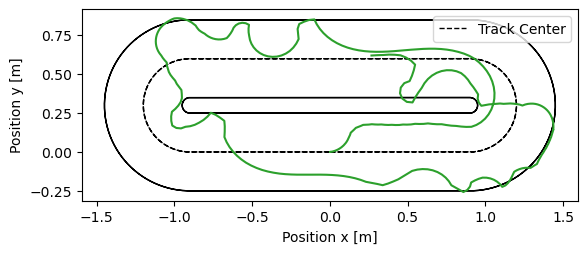

In [30]:
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('pdf', 'svg')
gen.populatePointsAndArcLength()
# gen.centerTrack()
_, ax = plt.subplots(1, 1)
ax = gen.plotPoints(ax)
# traj_0 = [global_trajectory[i] for i, val in enumerate(segment_index) if val == 0]
# traj_1 = [global_trajectory[i] for i, val in enumerate(segment_index) if val == 1]
# ax.plot([state[0] for state in traj_0], [state[1] for state in traj_0], color='tab:red')
# ax.plot([state[0] for state in traj_1], [state[1] for state in traj_1], color='tab:blue')
ax.plot([state[0] for state in global_trajectory], [state[1] for state in global_trajectory], color='tab:green')

/var/folders/sy/w5n70p7551x0x02tx8n0zk_r0000gn/T/ipykernel_41929/3459828878.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0,T],[a_min, a_min],'--', color='black', linestyle=':', linewidth=1)


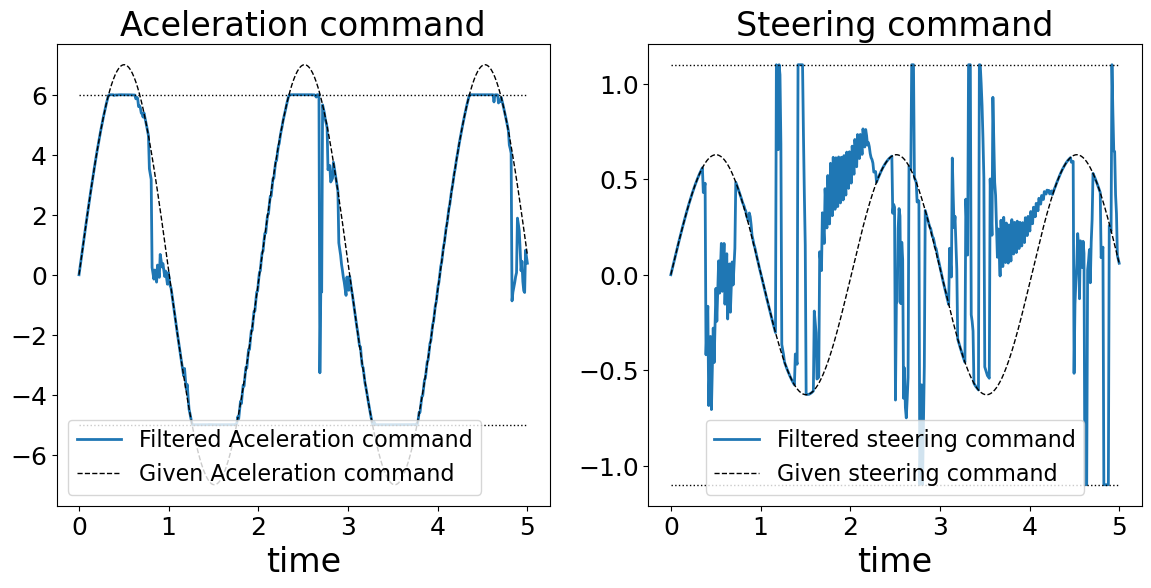

In [31]:
# plot given input and actual input
plt.figure(figsize=(14,6))
#velocity input
ax = plt.subplot(121)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.plot(np.linspace(0,T,len(traj_u)), [u[0,0] for u in traj_u], label='Filtered Aceleration command', color='tab:blue', linestyle='-', linewidth=2)
plt.plot(np.linspace(0,T,len(u_obj_list)), [u[0,0] for u in u_obj_list], label='Given Aceleration command', color='black', linestyle='--', linewidth=1)
# # plot constraint
p = plt.plot([0,T],[a_max, a_max], color='black', linestyle=':', linewidth=1)
# color = p[0].get_color()
plt.plot([0,T],[a_min, a_min],'--', color='black', linestyle=':', linewidth=1)
plt.legend()
plt.xlabel(r'time', fontsize=24)
# plt.ylabel(r'Aceleration command', fontsize=24)
plt.title('Aceleration command', fontsize=24)
plt.legend(loc='lower left', fontsize=16)

#steering (beta) input
ax = plt.subplot(122)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=6)
plt.plot(np.linspace(0,T,len(traj_u)), [u[1,0] for u in traj_u], label='Filtered steering command', color='tab:blue', linestyle='-', linewidth=2)
plt.plot(np.linspace(0,T,len(u_obj_list)), [u[1,0] for u in u_obj_list], label='Given steering command', color='black', linestyle='--', linewidth=1)
# # plot constraint
p = plt.plot([0,T],[delta_max, delta_max], color='black', linestyle=':', linewidth=1)
# color = p[0].get_color()
plt.plot([0,T],[-delta_max, -delta_max], color='black', linestyle=':', linewidth=1)
plt.xlabel(r'time', fontsize=24)
# plt.ylabel(r'steering command', fontsize=24)
plt.title('Steering command', fontsize=24)
plt.legend(fontsize=16)

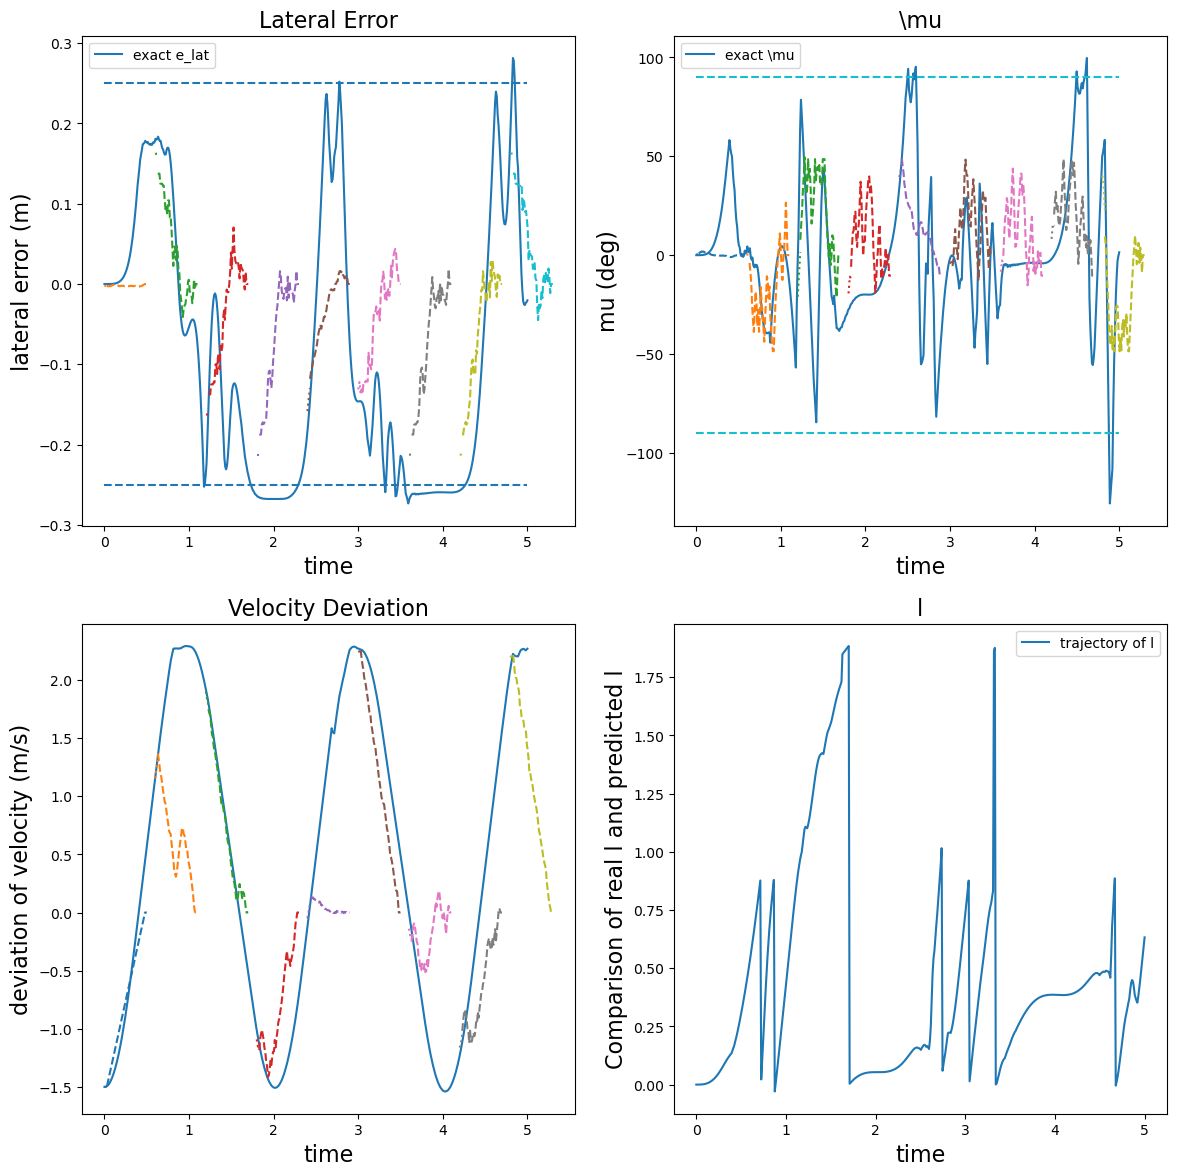

In [32]:
# plot error trajectory
import math
plt.figure(figsize=(14,14))
# e_lat
plt.subplot(221)
p = plt.plot(np.linspace(0,T,len(error_trajectory)), [error_state[0] for error_state in error_trajectory], label='exact e_lat')
color_exact = p[0].get_color()
plt.xlabel(r'time', fontsize=16)
plt.ylabel(r'lateral error (m)', fontsize=16)
plt.title('Lateral Error', fontsize=16)

# plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[:o*(steps):o], ":")
    color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)::o], "--", color=color)

# plot constraint
p = plt.plot([0,T],[track_width/2, track_width/2],'--')
color = p[0].get_color()
plt.plot([0,T],[-track_width/2, -track_width/2],'--', color=color)
plt.legend()

#mu
plt.subplot(222)
plt.plot(np.linspace(0,T,len(error_trajectory)), [(z[1])*180/math.pi  for z in error_trajectory], color=color_exact, label='exact \mu')
plt.xlabel(r'time', fontsize=16)
plt.ylabel(r'mu (deg)', fontsize=16)
plt.title('\mu', fontsize=16)

#plot predicted trajectory
for i, y_predicted in predicted_trajs.items():
    p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[1:o*(steps)+1:o]*180/math.pi, ":")
    color = p[0].get_color()
    plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[o*(steps)+1::o]*180/math.pi, "--", color=color)

# plot constraint
mu_max_deg = mu_max*180/math.pi
mu_min_deg = mu_min*180/math.pi
p = plt.plot([0,T],[mu_max_deg, mu_max_deg ],'--')
color = p[0].get_color()
plt.plot([0,T],[mu_min_deg, mu_min_deg],'--', color=color)
plt.legend()

if True:
    #v
    plt.subplot(223)
    p = plt.plot(np.linspace(0,T,len(error_trajectory)), [z[2]-v_0 for z in error_trajectory], label='exact v_error',color=color_exact)
    plt.xlabel(r'time', fontsize=16)
    plt.ylabel(r'deviation of velocity (m/s)', fontsize=16)
    plt.title('Velocity Deviation', fontsize=16)

    # plot predicted trajectory
    for i, y_predicted in predicted_trajs.items():
        p = plt.plot(np.linspace(i*Ts, (i+steps)*Ts, steps), y_predicted[2:2+o*(steps):o], ":")
        color = p[0].get_color()
        plt.plot(np.linspace((i+steps)*Ts, (i+L)*Ts, L-steps), y_predicted[2+o*(steps)::o], "--", color=color)
if True:
    #l
    plt.subplot(224)

    p = plt.plot(np.linspace(0,T,len(error_trajectory)), [z[3] for z in error_trajectory], label='trajectory of l',color=color_exact)
    # #plot predicted trajectory
    # for i, l_traj in predicted_l_trajs.items():
    #     # p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), [z[1,0] for z in y_predicted[:lag]], ":")
    # #     p = plt.plot(np.linspace((i-lag)*Ts, i*Ts, lag), y_predicted[1:3*lag+1:3], ":")
    #     p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), l_traj)
    # #plot real trajectory
    # for i, error_state_traj in real_trajs_under_u.items():
    #     p = plt.plot(np.linspace(i*Ts, (i+L)*Ts, L), [error_state[3] for error_state in error_state_traj], ':')

    plt.xlabel(r'time', fontsize=16)
    plt.ylabel(r'Comparison of real l and predicted l', fontsize=16)
    plt.title('l', fontsize=16)
    plt.legend()

In [33]:
print(min(sigma_norm))
print(max(sigma_norm))

2.574936353028079e-08
0.106537052893241
